## Setup

In [61]:
import numpy as np
rng = np.random.default_rng()  
import matplotlib.pylab as plt

## Helpful recources

https://hef.ru.nl/~tbudd/mct/lectures/markov_chain_monte_carlo.html

https://hef.ru.nl/~tbudd/mct/lectures/cluster_algorithms.html

## The 2D Ising model
The Ising model is a classical way of describing ferromagnetism using simplified spin-spin interactions. The 2D version of the Ising model considers an $w$ by $w$ square lattice, resulting in $N=w^2$ spin sites. If the lattice is given periodic boundary conditions, as is conventional, each spin will have exactly 4 neighbouring spins. The energy of the system is then given by

$ E = -J \sum_i \sum_j s_i s_j - \mu H \sum^{N}_{i=1} s_i $

where we sum over all spins $s_i$ and their neighbours $s_j$ with exchange energy $J$, magnetic moment $\mu$, and externally applied magnetic field $H$.

The most interesting variable of the system is the relative magnetisation of the complete lattice 

$M = \frac{1}{N}\sum_i^N s_i$

or the expected total magnetisation

$\mathbb{E}[M(\mathbf{s})]=\sum_{s \in\{-1,1\}^N}M(s) p_{\mathbf{s}}(s)$

with $p_{\mathbf{s}}(s)$ the probability mass function. The magnetisation shows a very strong dependence on the temperature as well as the externally applied magnetic field $H$. The magnetisation can also show a high variance. 

The analytical approach to calculate compute these expected values would be to use the probability mass function 

$p_{\mathbf{s}}(s)=\frac{1}{Z} e^{-\beta E}$

with partition function

$Z=\sum_{s \in\{-1,1\}^N} e^{-\beta E}$

and inverse temperature $\beta = \frac{1}{k_bT}$. However, computing this type of partition function quickly becomes arduous or simply infeasible for a lattice with any interesting number of spins, especially if the variance is also high. We thus typically use computational methods to investigate such systems and estimate the magnetisation $M$.

## A Monte Carlo model
The first steps of making the model will be to construct the lattice and several functions that compute essential properties of the system.

In [2]:
def init_lattice(width,type):
    '''Produce an initial lattice with spins. Type 1 gives all spins 1, type 0 gives a random spins, type -1 gives all spins -1. Captures invalid types.'''
    # TO DO
    if type == 1:
      return np.full((width, width), 1)
    elif type == -1:
      return np.full((width, width), -1)
    elif type == 0:
      return np.random.choice([-1, 1], size=(width,width))
    else:
      print('invalid input')
      return 0
def neighbouring_sites(i,j,width):
    '''Return the coordinates of the 4 sites adjacent to [i,j] on an width*width lattice. Takes into account periodic boundary conditions.'''
    # TO DO
    neighbour = []
    neighbour.append([(i+1)%width, j]) 
    neighbour.append([(i-1)%width, j]) 
    neighbour.append([i, (j+1)%width]) 
    neighbour.append([i, (j-1)%width]) 
    return neighbour
def neighbouring_spins_sum(i,j,lattice,width):
    '''Sums the spins of all neighbours of the spin at [i,j].'''
    # TO DO
    # print([lattice[site] for site in neighbouring_sites(i,j,width)])
    return np.sum([lattice[site[0], site[1]] for site in neighbouring_sites(i,j,width)])
def compute_magnetisation(lattice):
    '''Computes the magnetisation of the lattice.'''
    # TO DO (np.sum() may be useful)
    return (1/len(lattice)**2) * np.sum(lattice)
def plot_lattice(lattice,ax,title):
    '''Plot the lattice configuration.'''
    ax.matshow(lattice, vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

In [3]:
# sanity check
width = 6
lattice = init_lattice(width,0)
print('lattice:', lattice)
print('top-left corner site neighbor magnitization:', neighbouring_spins_sum(0,0,lattice,width))
print('total magnitization:', compute_magnetisation(lattice))

lattice: [[ 1 -1  1 -1  1 -1]
 [ 1  1 -1  1 -1 -1]
 [ 1 -1 -1 -1 -1 -1]
 [ 1 -1  1  1  1 -1]
 [ 1 -1  1  1  1  1]
 [ 1  1  1  1  1 -1]]
top-left corner site neighbor magnitization: 0
total magnitization: 0.16666666666666666


In [4]:
compute_magnetisation(init_lattice(12,-1))

-1.0

Note that 1 is black and -1 is white

## The Metropolis-Hastings algorithm
In order to be physically accurate, the transitions rates in our system have to satisfy detailed balance. The Metropolis-Hastings algorithm provides us with a way to select such transition rates without a need for knowing the normalisation of the probability distribution. 

$P(s_i \rightarrow -s_i) = \min \left(1, e^{-(\beta E_{-s_i}-\beta E_{s_i})}\right) = \min \left(1, e^{-\beta \Delta E}\right) = \begin{cases}1 & \text { if } \Delta E \leq 0 \\ e^{-\beta\Delta E} & \text { if } \Delta E > 0 \end{cases}$

where $\Delta E$ is the change in energy of the total lattice.

$\Delta E = 2J s_i \sum_j s_j + 2 \mu H s_i $

With this we can set up way to evolve the system. For convenience, it may be useful to define the interaction energies in terms of $\beta J$ and $\beta \mu H$.

In [5]:
def compute_betaDeltaE(i,j,lattice,width,betaJ,betaMuH):
    '''Computes the energy difference between the old and new state if spin [i,j] would be flipped.'''
    # TO DO
    E = 2 * betaJ * lattice[i,j] * neighbouring_spins_sum(i,j, lattice, width) + 2 * betaMuH * lattice[i,j]
    return E
def attempt_spin_flip(lattice,width,betaJ,betaMuH):
    '''Applies the Metropolis-Hastings algorithm to try and flip a spin.'''
    # TO DO
    w = len(lattice)
    i,j = rng.integers(0,w,2)
    if compute_betaDeltaE(i,j,lattice,width,betaJ,betaMuH) <= 0 or rng.random() < np.exp(-1 * compute_betaDeltaE(i,j,lattice,width,betaJ,betaMuH)):
        lattice[i,j] *= -1
    return lattice
def evolve_and_plot(lattice,betaJ,betaMuH,plot_times):
    '''Evolves the lattice using the Metropolis-Hastings algorithm and plots the lattice at different times.'''
    # TO DO
    fig, ax = plt.subplots(1,len(plot_times),figsize=(12,4))
    for t in range(plot_times[-1]+1):
        # TO DO
        if t in plot_times:
            plot_lattice(lattice,ax[plot_times.index(t)],"t = {}".format(t))
        attempt_spin_flip(lattice,len(lattice),betaJ,betaMuH)
    plt.show()

def evolve_and_compute_M(lattice,betaJ,betaMuH,avg_times):
    '''Evolves the lattice using the Metropolis-Hastings algorithm and returns the average magnetisation computed using different time steps.'''
    # TO DO
    magnetisation = []
    for t in range(avg_times[-1]+1):
        if t in avg_times:
            magnetisation.append(compute_magnetisation(lattice))
        attempt_spin_flip(lattice, len(lattice), betaJ, betaMuH)
    return magnetisation

## Testing the model
Evolve the system and plot it at various time steps to see if it appears to behave properly. Let's first get a feel for what a random lattice really looks like. Consider a system with no coupling $\beta J = 0$ and external magnetic field $\beta \mu H = 0$. Try both starting with a random lattice and a lattice with all spins in one direction.

[[-1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1]
 [ 1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1]
 [-1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1]
 [ 1 -1  1 -1  1 -1 -1 -1 -1 -1  1  1]
 [-1  1  1  1  1 -1 -1 -1  1  1  1  1]
 [ 1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1]
 [ 1 -1  1 -1 -1  1 -1  1 -1 -1 -1 -1]
 [ 1  1  1 -1 -1  1  1 -1 -1 -1 -1  1]
 [ 1  1 -1  1 -1 -1 -1  1  1 -1 -1  1]
 [-1  1 -1  1 -1  1 -1 -1 -1 -1  1 -1]
 [-1  1  1 -1  1 -1 -1 -1 -1 -1  1 -1]
 [ 1 -1  1  1 -1  1 -1  1  1 -1 -1  1]]


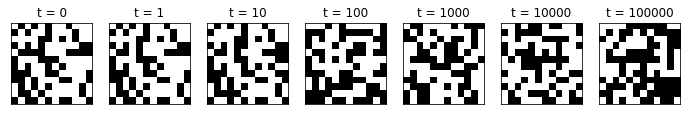

In [ ]:
# Testing the Metropolis-Hastings algorithm
plot_times = [0,1,10,100,1000,10000,100000]

# TO DO
# random matrix
lattice_test = init_lattice(width=12, type=0)
betaJ_test = 0
betaMuH_test = 0
print(lattice_test)
evolve_and_plot(lattice_test,betaJ_test,betaMuH_test,plot_times)

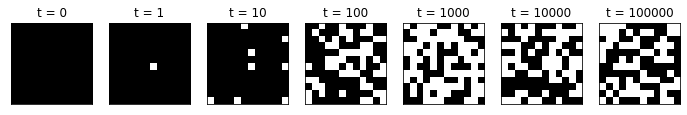

In [ ]:
# all up
lattice_test_up = init_lattice(width=12, type=1)
evolve_and_plot(lattice_test_up,betaJ_test,betaMuH_test,plot_times)

## Limiting case 1: only an external field
When $beta J=0$ there is no coupling. In such a case, only thermal motion and the external magnetic field affect the flipping of the spins. Do a few simulations with $-3 < \beta \mu H < 3$ and observe what happends. Again try both starting with a random lattice and a lattice with all spins in one direction. Qualitatively explain the system behaviour.

## Random matrix

$\beta \mu H = 0.1$

[[-1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1]
 [-1 -1 -1  1  1 -1 -1  1 -1  1 -1  1]
 [ 1  1 -1  1  1  1 -1  1 -1 -1 -1 -1]
 [ 1 -1  1 -1  1 -1 -1  1  1  1  1 -1]
 [-1  1  1  1 -1  1  1  1  1 -1 -1 -1]
 [ 1  1 -1 -1 -1 -1  1  1  1  1  1  1]
 [ 1 -1 -1  1  1 -1 -1 -1 -1  1 -1  1]
 [ 1 -1 -1  1  1 -1 -1  1 -1 -1  1 -1]
 [-1 -1 -1  1 -1 -1  1  1  1  1 -1  1]
 [ 1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1]
 [ 1 -1  1  1  1 -1 -1 -1 -1 -1  1  1]
 [-1 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1]]


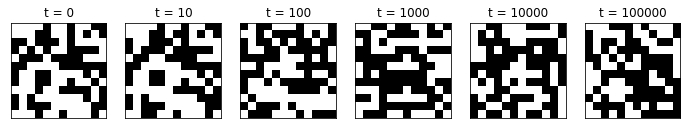

In [ ]:
plot_times = [0,10,100,1000,10000,100000]

# TO DO
random_lattice = init_lattice(12, type=0)
print(random_lattice)
evolve_and_plot(lattice=random_lattice.copy(),betaJ=0,betaMuH=0.1,plot_times=plot_times)

$\beta \mu H = 2.5$

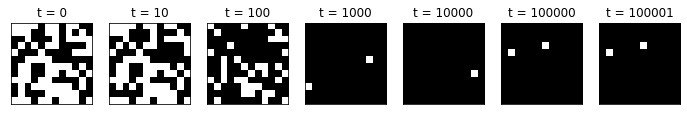

In [ ]:
evolve_and_plot(lattice=random_lattice.copy(),betaJ=0,betaMuH=2.5,plot_times=plot_times+[100001])

For a random spin configuration, when $\beta \mu H > 0$, if spin is up then $\Delta E >0$, it is 100% that the spin direction will change. While for spin down, there is a probabiity associated with the thermal&magnetic effect. The larger the $\beta \mu H$ is, comparing 2.5 to 0.1, the less likely the spin will flip. To summarize, small $\beta \mu H $ value will randomize the spin state and stay random because it's a large probabilistic value but large $\beta \mu H $ can 'de-excite' all state to spin down and stay up as demonstrated above.

$\beta \mu H = -0.1$

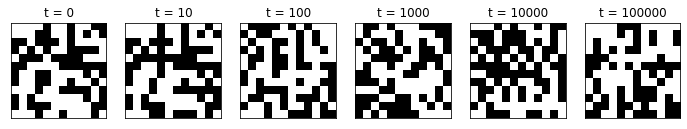

In [ ]:
evolve_and_plot(lattice=random_lattice.copy(),betaJ=0,betaMuH=-0.1,plot_times=plot_times)

$\beta \mu H = -2.5$

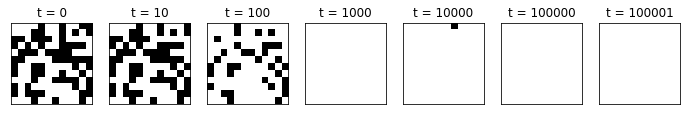

In [ ]:
evolve_and_plot(lattice=random_lattice.copy(),betaJ=0,betaMuH=-2.5,plot_times=plot_times+[100001])

When $\beta \mu H < 0$, the opposite happens: if spin is down, it will flip while for up, this depends on $\beta \mu H$. And the larger the value the less likely the spin state changes because of external field. So larger $\beta \mu H $ makes it more likely to stay in up state as above.

## All spin down case

$\beta \mu H = 2.5$

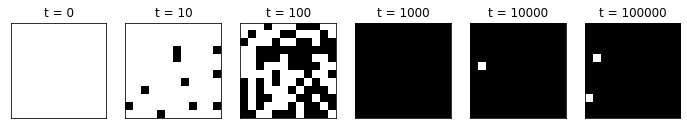

In [ ]:
evolve_and_plot(lattice=init_lattice(12, type=-1),betaJ=0,betaMuH=2.5,plot_times=plot_times)

once flipped up(negative $\Delta E$ flips 100%) with large $\beta \mu H$ it is hard to flip back because of exponentially small probability.

$\beta \mu H = -2.5$

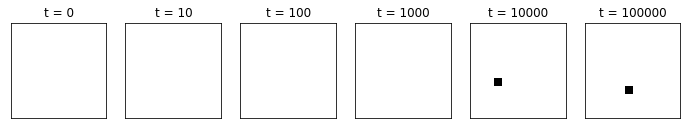

In [ ]:
evolve_and_plot(lattice=init_lattice(12, type=-1),betaJ=0,betaMuH=-2.5,plot_times=plot_times)

Opposite to above and with energy being negative it is almost never going up again.

## All spin up case

$\beta \mu H = 1$

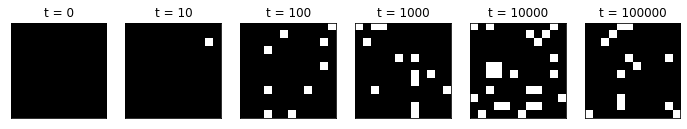

In [ ]:
evolve_and_plot(lattice=init_lattice(12, type=1),betaJ=0,betaMuH=1,plot_times=plot_times)

$\beta \mu H = -1$

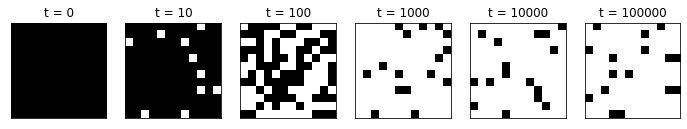

In [ ]:
evolve_and_plot(lattice=init_lattice(12, type=1),betaJ=0,betaMuH=-1,plot_times=plot_times)

$\Delta E >0$ for positive spin up spin and $\beta \mu H > 0$, so almst stay up. While some chance for spin flip happen when $\beta \mu H < 0$

## Magnitisation

In the case of no coupling, an analytical expression for the mean magnetisation $\langle M\rangle$ exists. The expression is:

$\langle M\rangle = \tanh \left(\beta \mu H \right)$

Show that the Monte Carlo method correctly repoduces the above analytical formula.

[[-1 -1 -1  1 -1 -1  1  1 -1 -1 -1  1]
 [ 1  1 -1  1  1  1  1 -1  1  1  1 -1]
 [ 1  1 -1 -1  1 -1 -1 -1  1  1 -1 -1]
 [-1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1]
 [-1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1]
 [ 1 -1 -1  1 -1 -1 -1  1  1  1 -1 -1]
 [ 1  1  1  1  1  1 -1  1 -1  1 -1 -1]
 [ 1  1 -1 -1  1  1  1 -1 -1  1 -1  1]
 [-1  1 -1  1  1 -1  1  1 -1 -1  1  1]
 [-1  1 -1  1  1  1 -1  1 -1  1  1  1]
 [ 1 -1 -1  1  1 -1  1 -1 -1  1  1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1]]


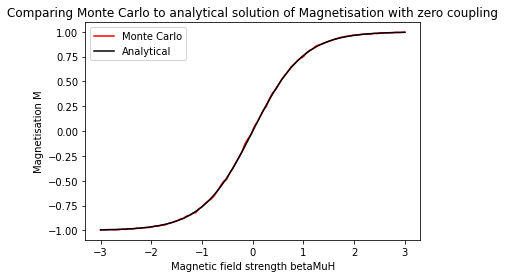

In [ ]:
betaMuHs_analytical = np.linspace(-3,3,100) # betaMuH values to plot
M_analytical = np.tanh(betaMuHs_analytical)

avg_times = np.arange(10000,100000,1000)
# Pick some suitable time points at which to sample your magnetisation. These values should be averaged to get a stable mean

# TO DO: Simulate the system at different magnetic field strengths
lattice=init_lattice(12, type=0)
print(lattice)
M = []
for b in betaMuHs_analytical:
  M.append(np.average(evolve_and_compute_M(lattice,0,b,avg_times)))
plt.plot(betaMuHs_analytical, M, 'r', label='Monte Carlo')
plt.plot(betaMuHs_analytical, M_analytical, 'black', label='Analytical')
plt.xlabel ('Magnetic field strength betaMuH')
plt.ylabel ('Magnetisation M')
plt.legend(loc='upper left')
plt.title('Comparing Monte Carlo to analytical solution of Magnetisation with zero coupling')
plt.show()

## Limiting case 2: only coupling

Now let us investigate coupling without an external magnetic field. Try the same as previously, using different starting conditions, but introduce some ferromagnetic coupling ($\beta J = 0.2$) or anti-ferromagnetic coupling ($\beta J = -0.2$). Qualitatively explain the system behaviour.

## All spin up case

In [40]:
spin_up_lattice = init_lattice(12, type=1)
print(spin_up_lattice)

[[1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]]


ferromagnetic coupling ($\beta J = 0.2$)

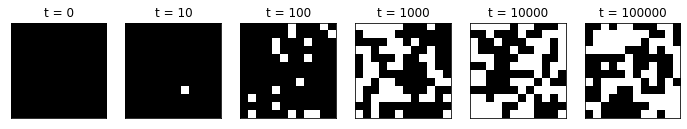

In [ ]:
evolve_and_plot(lattice=spin_up_lattice.copy(),betaJ=0.2,betaMuH=0,plot_times=plot_times)

antiferromagnetic coupling ($\beta J = -0.2$)

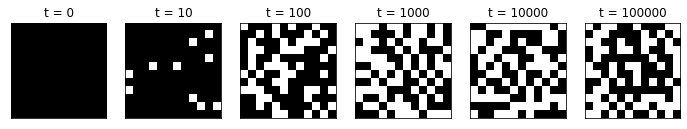

In [ ]:
evolve_and_plot(lattice=spin_up_lattice.copy(),betaJ=-0.2,betaMuH=0,plot_times=plot_times)

ferromagnetic coupling ($\beta J = 1$)

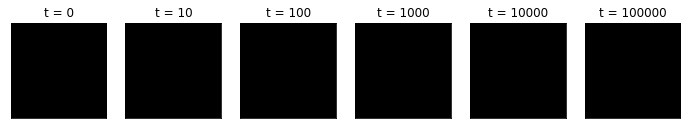

In [42]:
plot_times = [0,10,100,1000,10000,100000]
evolve_and_plot(lattice=spin_up_lattice.copy(),betaJ=1,betaMuH=0,plot_times=plot_times)

note above case the coupling is above critical temperature which gives a net magnetisation of 1 for ferromagnetics

## Random matrix

ferromagnetic coupling ($\beta J = 0.2$)

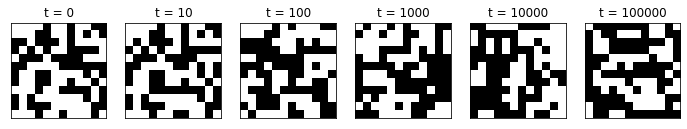

In [ ]:
evolve_and_plot(lattice=random_lattice.copy(),betaJ=0.2,betaMuH=0,plot_times=plot_times)

antiferromagnetic coupling ($\beta J = -0.2$)

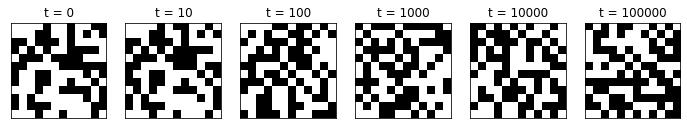

In [ ]:
evolve_and_plot(lattice=random_lattice.copy(),betaJ=-0.2,betaMuH=0,plot_times=plot_times)

## All spin down case

ferromagnetic coupling ($\beta J = 0.2$)

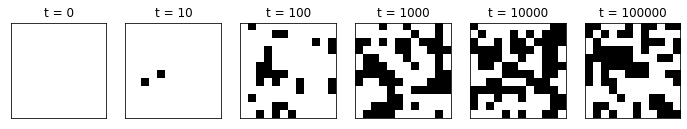

In [ ]:
evolve_and_plot(lattice=init_lattice(12, type=-1),betaJ=0.2,betaMuH=0,plot_times=plot_times)

antiferromagnetic coupling ($\beta J = -0.2$)

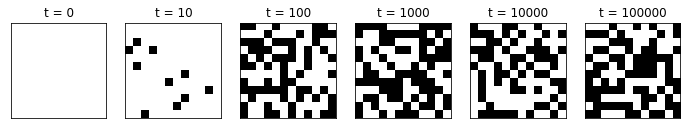

In [ ]:
evolve_and_plot(lattice=init_lattice(12, type=-1),betaJ=-0.2,betaMuH=0,plot_times=plot_times)

We can see in all three cases above, ferromagnetic tend to have clustered spins, meaning that spin state wants to align with each other. However, antiferromagnetic tends to have sparse spin state.

## Magnetisation

Also for this case, no field and only coupling, Lars Onsanger discovered an analytical solution:

$\langle M\rangle= \begin{cases}0 & \text { if } T \geq T_c \\ \pm \left(1-\sinh \left(2 \beta J\right)^{-4}\right)^{\frac{1}{8}} & \text { if } T<T_c\end{cases}$

where $T_c$ is the critical temperature given by

$T_c=\frac{2 J}{k_b \ln (1+\sqrt{2})}$

Show again that the Monte Carlo method correctly repoduces the above analytical formula. What do you notice about the system around the critical point?

Hint: The system will equilibrate much faster if you start with an initial state that is close to the expected final state.

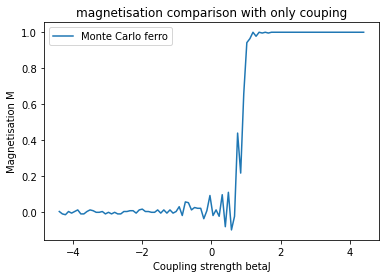

In [57]:
betaJ_analytical = np.linspace(-5*np.log(1+np.sqrt(2)),5*np.log(1+np.sqrt(2)),100)

avg_times = np.arange(8000,10000,1000)
# Pick some suitable time points at which to sample your magnetisation. These values should be averaged to get a stable mean
lattice_up=init_lattice(15, type=1)
ferro = []
for beta in betaJ_analytical:
    ferro.append(np.average(evolve_and_compute_M(lattice_up, 0.5*beta, 0, avg_times)))

plt.plot(betaJ_analytical, ferro, label="Monte Carlo ferro")
plt.title('magnetisation comparison with only couping')
plt.xlabel ('Coupling strength betaJ')
plt.ylabel ('Magnetisation M')
plt.legend(loc='upper left')
plt.show()

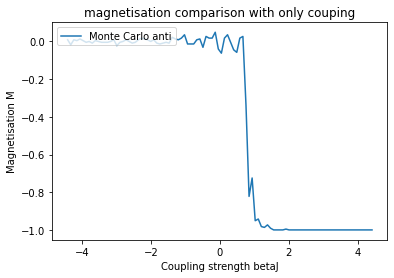

In [64]:
betaJ_analytical = np.linspace(-5*np.log(1+np.sqrt(2)),5*np.log(1+np.sqrt(2)),100)
lattice_anti = init_lattice(15, type=-1)
anti = []
for beta in betaJ_analytical:
    anti.append(np.average(evolve_and_compute_M(lattice_anti, 0.5*beta, 0, avg_times)))

plt.plot(betaJ_analytical, anti, label="Monte Carlo anti")
plt.title('magnetisation comparison with only couping')
plt.xlabel ('Coupling strength betaJ')
plt.ylabel ('Magnetisation M')
plt.legend(loc='upper left')
plt.show()

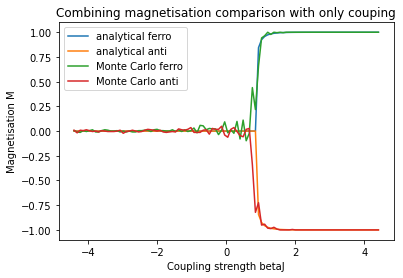

In [66]:
# betaJ_analytical = np.linspace(-5*np.log(1+np.sqrt(2)),5*np.log(1+np.sqrt(2)),100)
M_analytical = np.zeros((100,))
for i in range(40):
  M_analytical[60+i] = (1-np.sinh(betaJ_analytical[60+i])**(-4))**(1/8)

# avg_times = np.arange(8000,10000,1000)
# Pick some suitable time points at which to sample your magnetisation. These values should be averaged to get a stable mean
# lattice_up=init_lattice(15, type=1)
# lattice_anti=np.resize([1,-1], (15,15))
# ferro = []
# anti = []
# for beta in betaJ_analytical:
#     ferro.append(np.average(evolve_and_compute_M(lattice_up, 0.5*beta, 0, avg_times)))
#     anti.append(np.average(evolve_and_compute_M(lattice_anti, -0.5*beta, 0, avg_times)))

plt.plot(betaJ_analytical, M_analytical, label="analytical ferro")
plt.plot(betaJ_analytical, -M_analytical, label="analytical anti")
plt.plot(betaJ_analytical, ferro, label="Monte Carlo ferro")
plt.plot(betaJ_analytical, anti, label="Monte Carlo anti")
plt.title('Combining magnetisation comparison with only couping')
plt.xlabel ('Coupling strength betaJ')
plt.ylabel ('Magnetisation M')
plt.legend(loc='upper left')
plt.show()

There is a sudden drop near the critical temperature.

## Optional: implement the Wolff algorithm
**One more non-optional exercise after this, please look ahead.** In some cases, as you might realise in the next exercise, it can take quite long for the Metropolis-Hastings algorithm to sample the state space of the system. The Wolff algorithm was developed to speed up the exploration of the state space by flipping multiple spins (of the same sign) at once.

The algorithm works as follows:

- Select a spin $s_i$ at random

- Start checking all neighbouring spins $s_j$

- Add a neighbouring spin $s_j$ to the cluster with probability $P_{add} = 1-\exp(-\beta \Delta E)$, but only if it has the same sign as $s_i$

- Repeat until no unvisited neighbours remain

- Flip all spins

Implement Wolff algorithm and compare the equilibration speed to that of the Metropolis-Hastings algorithm for a system with only coupling ($\beta J=0.2$). Hint: In practice it is more convenient to already flip all visited spins.

For the interested reader, an even more efficient method is the Swendsen-Wang algorithm (https://en.wikipedia.org/wiki/Swendsen%E2%80%93Wang_algorithm).

In [ ]:
def spin_flip_wolff(lattice,width,betaJ,betaMuH):
    '''Applies the Wolff algorithm to try and flip a spin.'''
    i,j = rng.integers(0,width,2) # Select a random seed
    # TO DO
    cluster = [[i,j]]
    s = lattice[i,j]
    unvisited = neighbouring_sites(i,j,width)
    while (len(unvisited)>0):   # while unvisited sites remain
        i,j = unvisited.pop(0)  # take one and remove from the unvisited list
        for x,y in neighbouring_sites(i,j,width):
            # TO DO
            if s == lattice[x,y] and rng.random() <= 1-np.exp(-0.4*s*neighbouring_spins_sum(x,y,lattice,width)) and [x,y] not in cluster:
              cluster.append([x,y])
              unvisited.append([x,y])
    for site in cluster:
      lattice[site[0], site[1]] *= -1
    return lattice

def evolve_and_plot_wolff(lattice,betaJ,betaMuH,plot_times):
    '''Evolves the lattice using the Wolff algorithm and plots the lattice at different times.'''
    # TO DO
    fig, ax = plt.subplots(1,len(plot_times),figsize=(12,4))
    for t in range(plot_times[-1]+1):
        # TO DO
        if t in plot_times:
            plot_lattice(lattice,ax[plot_times.index(t)],"t = {}".format(t))
        spin_flip_wolff(lattice, len(lattice), betaJ, betaMuH)
    plt.show()

[[1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]]


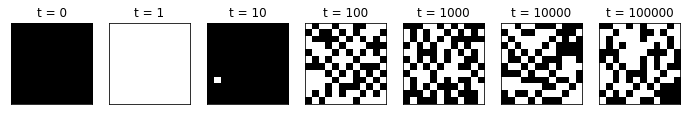

In [ ]:
# Testing the Wolff algorithm if it has been implemented

# TO DO
plot_times = [0,1,10,100,1000,10000,100000]
lattice_test = init_lattice(width=12, type=1)
betaJ_test = 0.2
betaMuH_test = 0
print(lattice_test)
evolve_and_plot_wolff(lattice_test,betaJ_test,betaMuH_test,plot_times)

This is much faster than the previous algorithm

## Mandatory: Magnetic susceptibility
A common problem in physical simulations is that we are limited in the size of the systems that we can simulate within a reasonable time. Periodic boundary conditions are typically a good way of circumventing problems caused by finite systems, but some problems cannot be circumvented that easily. The magnetisation of the 2D Ising model shows a continuous phase transition, and statistical physics tells us the correlation length $\xi$ of the system thus follows the relation

$\xi \sim\left|T-T_c\right|^{-\nu}$

with $\nu$ is called the critical exponent. This means that the correlation length will quickly diverge near the critical point and correlate most, if not all, spins in the system with each other. This strongly affects the magnetic susceptibility $\chi$ that is defined as

$\chi=\frac{1}{N} \frac{\partial M}{\partial H}=\frac{\beta}{N}\left(\left\langle M^2\right\rangle-\langle M \rangle^2\right)$.

Run a number of tests to see how the magnetic susceptibility $\chi$ changes as the critical temperature of the system is approached. Repeat this for a smaller or larger lattice. What does this tell you about our ability to get accurate average properties for the system near the critical temperature?

Note: It is more convenient to use the definition of magnetic susceptibility that uses the variance of the magnetisation than the definition of the gradient w.r.t. the magnetic field.

In [ ]:
def evolve_and_computeChi(lattice,betaJ,betaMuH,avg_times):
    '''Evolves the lattice using the Metropolis-Hastings algorithm and computes the average magnetisation using different time steps.'''
    # TO DO
    Chi = []
    def var(lattice, M):
      var = []
      for i in range(len(lattice)):
        for j in range(len(lattice)):
          var.append((lattice[i][j]-M)**2)
      return np.sum(var)
    for t in range(avg_times[-1]+1):
        lattice = attempt_spin_flip(lattice, len(lattice), betaJ, betaMuH)
        if t in avg_times:
          M = compute_magnetisation(lattice)
          v = var(lattice, M)
          Chi.append(v*betaJ)
    return np.average(Chi)

[[ 1 -1 -1  1  1 -1  1  1  1 -1  1 -1]
 [ 1  1 -1 -1  1  1 -1  1  1 -1 -1 -1]
 [-1 -1 -1 -1  1 -1  1  1  1  1  1  1]
 [-1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1]
 [-1  1 -1  1  1  1  1  1 -1  1 -1  1]
 [ 1 -1  1  1 -1  1  1  1 -1  1  1  1]
 [ 1  1  1 -1 -1 -1 -1 -1  1  1 -1  1]
 [ 1  1 -1  1  1 -1 -1  1 -1 -1  1 -1]
 [ 1 -1  1  1  1  1 -1  1  1  1 -1  1]
 [-1 -1  1  1  1 -1 -1 -1 -1 -1  1  1]
 [-1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1]
 [ 1  1  1 -1  1  1  1 -1  1 -1  1 -1]]


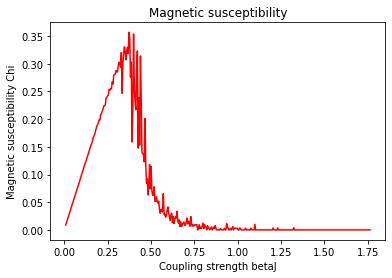

In [6]:
def evolve_and_computeChi(lattice,betaJ,betaMuH,avg_times):
    '''Evolves the lattice using the Metropolis-Hastings algorithm and computes the average magnetisation using different time steps.'''
    # TO DO
    Chi = []
    def var(lattice, M):
      var = []
      for i in range(len(lattice)):
        for j in range(len(lattice)):
          var.append((lattice[i][j]-M)**2)
      return np.sum(var)
    for t in range(avg_times[-1]+1):
        lattice = attempt_spin_flip(lattice, len(lattice), betaJ, betaMuH)
        if t in avg_times:
          M = compute_magnetisation(lattice)
          v = var(lattice, M)
          Chi.append(v*betaJ)
    return np.average(Chi)

critical_betaJ = np.log(1+np.sqrt(2))
beta_analytical = np.linspace(0.01*critical_betaJ,2*critical_betaJ,400) # betaMuH values to plot
avg_times = np.arange(1000,10000,1000)
# Pick some suitable time points at which to sample your magnetisation. These values should be averaged to get a stable mean
lattice=init_lattice(12, type=0)
print(lattice)
Chi = []
for b in beta_analytical:
  c = evolve_and_computeChi(lattice,b,0,avg_times)
  Chi.append(c)
plt.plot(beta_analytical, Chi, 'r')
# Simulate the system at different coupling strengths (relative to the critical temperature)
plt.title('Magnetic susceptibility')
plt.xlabel ('Coupling strength betaJ')
plt.ylabel ('Magnetic susceptibility Chi')
plt.show()

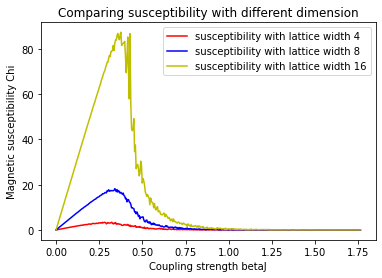

In [ ]:
# Smaller or larger lattice to show susceptibility changes
critical_betaJ = np.log(1+np.sqrt(2))
beta_analytical = np.linspace(0,2*critical_betaJ,400) # betaMuH values to plot
avg_times = np.arange(1000,100000,1000)
# Pick some suitable time points at which to sample your magnetisation. These values should be averaged to get a stable mean
lattice4 = init_lattice(4, type=0)
lattice8 = init_lattice(8, type=0)
lattice16 = init_lattice(16, type=0)
Chi_4 = []
Chi_8 = []
Chi_16 = []
for b in beta_analytical:
  c4 = evolve_and_computeChi(lattice4,b,0,avg_times)
  Chi_4.append(c4)
  c8 = evolve_and_computeChi(lattice8,b,0,avg_times)
  Chi_8.append(c8)
  c16 = evolve_and_computeChi(lattice16,b,0,avg_times)
  Chi_16.append(c16)
plt.plot(beta_analytical, Chi_4, 'r', label='susceptibility with lattice width 4')
plt.plot(beta_analytical, Chi_8, 'b', label='susceptibility with lattice width 8')
plt.plot(beta_analytical, Chi_16, 'y', label='susceptibility with lattice width 16')
# Simulate the system at different coupling strengths (relative to the critical temperature)
plt.legend()
plt.title('Comparing susceptibility with different dimension')
plt.xlabel ('Coupling strength betaJ')
plt.ylabel ('Magnetic susceptibility Chi')
plt.show()

As we can see, the peak value of susceptibility increase four folds as dimension doubles. This is because the critical temperature actually scales with the dimension N. As the dimension increases, the crtical temperature decreases and the critical couping increases (scale with 1/T) and we can see the shift in the plot. Therefore, to get an accurate value, considering both Onsanger's result and finite-size scaling, we need a large dimension

## Optional: Further assignments

**Investigate finite-size scaling of the lattice.** The critical temperature varies as a function of the lattice size $N=w*w$

$T_c(N) = T_c(\infty)+aN^{-1/b}$

with $a$ and $b$ being constants to estimate. Compare your estimated $T_c(\infty)$ to Onsanger's analytical result.

**Compute the decorrelation time of the magnetisation to determine the proper equilibration time.** The autovariance is defined as

$A(\tau)=\langle M'(t)M'(t+\tau) \rangle$

where $M'=M-\langle M \rangle$ and $\tau$ is the lag time. The autocorrelation is then given by $a(\tau)=\frac{A(\tau)}{A(0)}$. The decorrelation time can them be said to be $\tau$ for which $a(\tau)$ has dropped to $1/e$.

**Determine the heat capacity.** The fluctuation dissipation theorem states that the heat capacity of the system is given by

$C=\frac{\sigma_E}{k_B T^2} $

with $\sigma_E$ being the standard deviation in the system energy.

# Heat Capacity

In [ ]:
def calcEnergy(lattice):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(lattice)):
        for j in range(len(lattice)):
          e = compute_betaDeltaE(i,j,lattice,width,1,1)
          energy += e
    return energy

def evolve_and_compute_C(lattice,betaJ,betaMuH,avg_times):
    E = E2 = []
    for t in range(avg_times[-1]+1):
        if t in avg_times:
          e = calcEnergy(lattice)
          E.append(e)
          E2.append(e**2)
        lattice = attempt_spin_flip(lattice, len(lattice), betaJ, betaMuH)
    return np.average(E), np.average(E2)

nt      = 100         #  number of temperature points
N       = 12         #  size of the lattice, N x N
eqSteps = 1024       #  number of MC sweeps for equilibration
mcSteps = 1024       #  number of MC sweeps for calculation
lattice = init_lattice(N, type=0)
T       = np.linspace(1, 4, nt); 
C = np.zeros(nt)
n1, n2  = 1.0/(N*N), 1.0/(N*N) 

for i in range(nt):

    iT=1.0/T[i]; iT2=iT*iT;
    
    E1, E2 = evolve_and_compute_C(lattice,iT,0,avg_times)

    C[i] = (n1*E2 - n2*E1*E1)*iT2


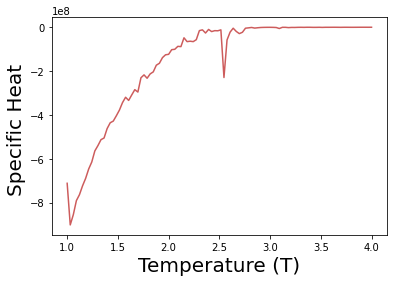

In [ ]:
plt.plot(T, C, color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);